### Data Gathering

I import 'twitter-archive-enhanced.csv' into a dataframe:

In [1]:
import pandas as pd
import numpy as np

twitter=pd.read_csv('twitter-archive-enhanced.csv')

I download the 'image predictions' file, save it into a .csv file and then import that file into a dataframe:

In [150]:
import requests

predictions=requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [151]:
open('image_predictions.csv','wb').write(predictions.content)

In [6]:
prediction=pd.read_csv('image_predictions.tsv',sep='\t',error_bad_lines=False)

I download the twitter data into a json .txt file, and then import the data into a dataframe:

In [153]:
# import tweepy

# consumer_key = 'XXXXXXXXXXXXXXXXXX'
# consumer_secret = 'XXXXXXXXXXXXXXXXXX'
# access_token = 'XXXXXXXXXXXXXXXXXX'
# access_secret = 'XXXXXXXXXXXXXXXXXX'

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [2]:
import json
tweets=[]
for line in open('tweet_json.txt','r'):
    try:
        tweets.append(json.loads(line))
    except ValueError:
        pass

In [3]:
tweets=pd.DataFrame(tweets)

This concludes the gathering part of the project. I move on to the next part, which is assessing the data.

## Assessing the data

I create copies for each dataframe. Then I look at each of them.

Finally, after I decide what I want to keep from each dataframe, I join them and then I just assess and clean the joined dataframe.

In [9]:
twitter_df=twitter.copy()
tweets_df=tweets.copy()
predictions_df=prediction.copy()

In [ ]:
print tweets_df.head(3)

In [ ]:
tweets_df.info()

I take a look at the `twitter_df` table as well:

In [ ]:
print twitter_df.head(3)

In [ ]:
twitter_df.info()

And I take a look at the predictions_df dataframe:

In [ ]:
predictions_df.head()

In [ ]:
predictions_df.info()

I join the `twitter_df` dataframe with the `tweets_df` dataframe. I use a left join, so that all the rows in `twitter_df` are preserved, but the tweet_ids that are not in `twitter_df` are removed. I only added the following columns from `tweets_df`: `retweet_count`, `favorite_count`, `entities`.

In [10]:
temporary_df=tweets_df[['id','retweet_count','favorite_count','entities']]
tweet_df=twitter_df.join(temporary_df.set_index('id'), on='tweet_id')  #joins the columns i want from tweets_df to twitter_df

I check to see the results of the join:

In [ ]:
print tweet_df.head(2)

In [ ]:
tweet_df.info()

Right away we notice some small things that need cleaning: 
    
The `retweet_count` and `favorite_count` columns are float. I'll cast them as integer (**\#1**)

The `tweet_id` column is also float, but this shouldn't be a number at all, since it functions more like a name. Therefore I'll cast it as a string. (**\#2**)

I also need to change the `timestamp` column to a datetime format. (**\#3**)

I want to take a closer look at the `text` column, and at the `expanded_urls` column.

In [12]:
for i in range(0,40):
    print tweet_df.loc[i,'text']
    print tweet_df.loc[i,'expanded_urls']
    print ""

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
https://twitter.com/dog_rates/status/892420643555336193/photo/1

This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
https://twitter.com/dog_rates/status/892177421306343426/photo/1

This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
https://twitter.com/dog_rates/status/891815181378084864/photo/1

This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
https://twitter.com/dog_rates/status/891689557279858688/photo/1

This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
https://twitter.com/dog_rates/status/89132755892668825

It looks like there are some retweets and replies in the data. The retweets' `text` column starts with 'RT' and the replies starts with '@'. I remove these rows from the table. (**\#4**)

I will also remove rows without an image, by removing rows where `expanded_urls` is nan. (**\#5**)

Let's look next at dog names. First I'll check to see how many dogs have no name. Second, it's likely that having used a regular expression to extract dog names might have selected also some words that are not dog names - so I'll check for 'names' that start with a lower-case letter.

In [167]:
tweet_df[tweet_df['name']=='None']['name'].count()

745

In [168]:
tweet_df[tweet_df['name'].str.islower()]['name'].count()

109

Let's see some of the entries where the dog names start with lower case. I'll print the `text` and `name` columns for each:

In [14]:
k=0
for i in tweet_df[tweet_df['name'].str.islower()].index:
    print tweet_df.loc[i,'text']
    print tweet_df.loc[i,'name']
    print ''
    k+=1
    if k>19:
        break

I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
such

Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af 
(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
a

RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…
quite

We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
quite

Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
quite

There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  
https://t.co/dp5h9bCwU7
not

Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK
one

We only ra

It looks like the regex used picked up the first word after 'This is' or 'Here is' and so on. In many of these cases, the `text` column doesn't contain any name whatsoever, so the `name` column should be empty. However, in some of these cases, the `text` column does contain a dog name. I'll try to build some regular expressions to capture the names, and for the rest I will just replace `name` value with 'None'. **\#6**

Next I look at the ratings. Although it's ok for the numerator to be higher than 10, the denominator should always be 10. Let's check:

In [15]:
k=0
for i in tweet_df[tweet_df['rating_denominator']!=10].index:
    print tweet_df.loc[i,'rating_denominator']
    print tweet_df.loc[i,'text']
    print ''
    k+=1
    if k>19:
        break

0
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho

15
@docmisterio account started on 11/15/15

70
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

7
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx

11
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…

150
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

11
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

170
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv

20
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a

50
This 

There are three problems: first, when the denominator is 10\*n, that's a rating for n dogs. Second, when the denominator is different than that, the regex used picked the wrong ratio ('7/11' refers to the store, for example, and it's not a rating). Third, there are cases when even if the denominator is 10, the numerator is identified incorrectly: '7.26/10' is identified as having a numerator of value '26'.

To fix this column, I will address the above issues in reverse order: first I construct a regex that only picks ratios that have a multiple of 10 as denominator. Then, for the ones whose denominator is different than 10, I normalize them. (**\#7**)

Let's take a look at what is in the 'entities' column:

In [171]:
tweet_df['entities'][0]

{u'hashtags': [],
 u'media': [{u'display_url': u'pic.twitter.com/MgUWQ76dJU',
   u'expanded_url': u'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   u'id': 892420639486877696,
   u'id_str': u'892420639486877696',
   u'indices': [86, 109],
   u'media_url': u'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   u'media_url_https': u'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   u'sizes': {u'large': {u'h': 528, u'resize': u'fit', u'w': 540},
    u'medium': {u'h': 528, u'resize': u'fit', u'w': 540},
    u'small': {u'h': 528, u'resize': u'fit', u'w': 540},
    u'thumb': {u'h': 150, u'resize': u'crop', u'w': 150}},
   u'type': u'photo',
   u'url': u'https://t.co/MgUWQ76dJU'}],
 u'symbols': [],
 u'urls': [],
 u'user_mentions': []}

I will extract some data from the `entities` column. To begin with, I want to extract `hashtags`, `symbols`, and `urls`. I'll decide what to keep from these after I take a look at the data. 


Finally, the four columns that indicate dog stage are all instances of the same variable, namely dog stage. So we can collapse these into a single column. (**\#8**)

Let's look at the prediction data:

In [172]:
predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [173]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


The most serious issue with this table seems to be that most columns represent values and not variables. p1, p2, and p3 contain dog breeds. p1_conf, p2_conf, and p3_conf indicate the likelihood the image shows a dog of the respective breed. and p1_dog, p2_dog, and p3_dog indicate whether they think the image is a dog or not. We can collapse these into three variables, 'dog_breed', 'likelihood', and 'is_dog'. 

The order is not important and thus nothing is lost. The difference between p1, p2, and p3 seems to be that p1 is always more likely than p2, which is always more likely than p3. However, if we needed to pick up the most likely breed for a dog, we can easily do that with max(), so the information contained in the order can be easily recovered. (**\#9**)

#### Summary of Assessment:

These are then the things I need to address: 

(1) Recast `retweet_count` and `favorite_count` columns as integer.

(2) Recast `tweet_id` as a string.

(3) Change the `timestamp` column to a datetime format.

(4) Remove rows where `text` column starts with 'RT' or '@' from the twitter_df.

(5) Remove rows where `expanded_urls` is nan.

(6) Clean up `dog_name` column: build some regular expressions to capture the names from `text` column, and when that fails I will replace name value with 'None'.

(7) Clean up `rating_denominator' and 'rating_numerator` columns: construct a regex that only picks ratios that have a multiple of 10 as denominator. Then, for the ones whose denominator is different than 10, I normalize them

(8) I collapse the following columns: `doggo`,`floofer`,`pupper`,`puppo` into a single column, `dog_stage`

(9) Collapse p1, p2, and p3 into `breed`; p1_conf, p2_conf, and p3_conf into `likelihood`; and p1_dog, p2_dog, and p3_dog into `is_dog` 

Further, I will make the following changes (the reason for these will only become apparent once we start cleaning the data in the next section):

(10) Extract `hashtags`, `urls` and `symbols` columns from (json-formatted) `entities` column

(11) Delete `urls` and `symbols` columns, along with the `entities` column

(12) Create a `hashtag_df` dataframe to record hashtags for each tweet_id (**\#10**)

In [ ]:
tweet_df.info()

## Cleaning the data

**Issue**

Columns with wrong types

**Define**

Recast `retweet_count` and `favorite_count` columns as integer.

Recast `tweet_id` as a string.

Change the `timestamp` column to a datetime format.

**Code**

In [20]:
tweet_df['retweet_count']=tweet_df['retweet_count'].fillna(0.0).astype(int)

tweet_df['favorite_count']=tweet_df['favorite_count'].fillna(0.0).astype(int)

tweet_df['tweet_id']=tweet_df['tweet_id'].astype(str)

tweet_df['timestamp']=pd.to_datetime(tweet_df['timestamp'])

**Test**

In [ ]:
tweet_df.info()

**Issue**

Remove retweets and replies from twitter_df

**Define**

Remove rows where `text` column starts with 'RT' or '@' from the twitter_df

**Code**

In [177]:
import re

for i in tweet_df.index:
    condition=(re.search("^RT",tweet_df.loc[i,'text']) is not None) or (re.search("^@",tweet_df.loc[i,'text']) is not None)
    if condition:
        tweet_df.drop(i, axis=0,inplace=True)
        
tweet_df.dropna(axis=0,subset=['expanded_urls'],inplace=True)

**Test**

In [178]:
lst=[]
k=1
for i in tweet_df.index:
    try:
        condition=(re.search("^RT",tweet_df.loc[i,'text']) is not None) or (re.search("^@",tweet_df.loc[i,'text']) is not None)
        if condition:
            k=0
            lst.append(i)
    except TypeError:
        print i
if k==0:
    print "There are still some retweets and/or replies in the tweet data. Please take a look at the following rows:"
    print lst
else:
    print "All retweets and replies have been dropped"

All retweets and replies have been dropped


**Issue**

Fix dog names

**Define**

Clean up `dog_name` column: build some regular expressions to capture the names from `text` column, and when that fails I will replace name value with 'None'.

**Code**

In [179]:
test=tweet_df[tweet_df['name'].str.islower()]
for i in test.index:
    if re.search("named\s[A-Z]\w*",test.loc[i,'text']) is not None:
        expression=re.search("named\s[A-Z]\w*",test.loc[i,'text']).group()
        test.loc[i,'name']=expression.split(' ')[1]
    elif re.search('That\sis\s[A-Z]\w*',test.loc[i,'text']) is not None:
        expression=re.search("That\sis\s[A-Z]\w*",test.loc[i,'text']).group()
        test.loc[i,'name']=expression.split(' ')[2]
    elif re.search('name\sis\s[A-Z]\w*',test.loc[i,'text']) is not None:
        expression=re.search("name\sis\s[A-Z]\w*",test.loc[i,'text']).group()
        test.loc[i,'name']=expression.split(' ')[2]
    else:
        test.loc[i,'name']=None
        
for i in test.index:
    tweet_df.loc[i,'name']=test.loc[i,'name']

**Test**

In [180]:
tweet_df['name'].str.islower().sum()

0

**Issue**

Fix rating columns.

**Define**

Construct a regex that only picks ratios that have a multiple of 10 as denominator. Then, for the ones whose denominator is different than 10, I normalize them

**Code**

In [181]:
for i in tweet_df.index:
    if re.search('\d+\.\d+/\d0',tweet_df.loc[i,'text']) is not None:
        tweet_df.loc[i,'rating_denominator']=int(re.search('\d+\.\d+/\d0',tweet_df.loc[i,'text']).group().split('/')[1])
        tweet_df.loc[i,'rating_numerator']=re.search('\d+\.\d+/\d0',tweet_df.loc[i,'text']).group().split('/')[0]
    elif re.search('\d+/\d+0',tweet_df.loc[i,'text']) is not None:
        tweet_df.loc[i,'rating_denominator']=int(re.search('\d+/\d+0',tweet_df.loc[i,'text']).group().split('/')[1])
        tweet_df.loc[i,'rating_numerator']=re.search('\d+/\d+0',tweet_df.loc[i,'text']).group().split('/')[0]
    else:
        tweet_df.loc[i,'rating_denominator']=10
        tweet_df.loc[i,'rating_numerator']=0

tweet_df['rating_numerator']=tweet_df['rating_numerator'].astype(float)
tweet_df['rating_denominator']=tweet_df['rating_denominator'].astype(float)
tweet_df['rating']=tweet_df['rating_numerator']/tweet_df['rating_denominator']

**Test**

In [182]:
tweet_df['rating_denominator'].isnull().sum()

0

**Issue**

Extract data from 'entities' column

**Define**

Extract `hashtags`, `urls` and `symbols` columns from (json-formatted) `entities` column

**Code**

In [183]:
def value_to_string(value,dic):
    st=''
    for element in dic[value]:
        st+=str(element)+'|'
    return st

def update_df(value):
    i=0
    for i in range (0,tweet_df.shape[0]):
        try:
            tweet_df.loc[i,value]=value_to_string(value,tweet_df.loc[i,'entities'])
            i=i+1
        except TypeError: # entities column is nan
            tweet_df.loc[i,value]=''
        except KeyError:
            tweet_df.loc[i,value]=''
            
update_df('urls')
update_df('hashtags')
update_df('symbols')

In [ ]:
tweet_df.head()

In [ ]:
tweet_df.info()

#### Interlude: More Assessment

Having cleaned up the data in the `entities` column, we need to look at what we should keep from this data. What follows is a brief assessment of the data we extracted, after which we go back to cleaning it. 

Let's look at what the `hashtags` column contains:

In [ ]:
tweet_df[tweet_df['hashtags']!=''].head(5)

It looks like the hashtag is buried a little deeper in the json structure, under the 'text' key. I want to keep this information, because I would like to see which hashtags are the most common. But before I do that I look at the other columns I created. Next is `symbols` column.

In [187]:
tweet_df[tweet_df['symbols']!=''].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,floofer,pupper,puppo,retweet_count,favorite_count,entities,rating,urls,hashtags,symbols


**Define**

This column is empty so I discard it.

**Code**

In [188]:
tweet_df.drop('symbols',axis=1,inplace=True)

**Test**

In [ ]:
tweet_df.info()

Next I look at `url` column:

In [190]:
tweet_df[tweet_df['urls']!=''].head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,doggo,floofer,pupper,puppo,retweet_count,favorite_count,entities,rating,urls,hashtags
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,None,None,None,None,2037.0,11681.0,"{u'symbols': [], u'user_mentions': [], u'hasht...",1.3,"{u'url': u'https://t.co/Zr4hWfAs1H', u'indices...",


The text in the `url` column is truncated, so I just choose one cell to print:

In [191]:
tweet_df.loc[6,'urls']

"{u'url': u'https://t.co/Zr4hWfAs1H', u'indices': [117, 140], u'expanded_url': u'https://gofundme.com/ydvmve-surgery-for-jax', u'display_url': u'gofundme.com/ydvmve-surgery\\u2026'}|"

I don't think I'll use this data.

**Define**

I remove `urls` column.

**Code**

In [192]:
tweet_df.drop('urls',axis=1,inplace=True)

**Test**

In [ ]:
tweet_df.info()

**Define**

I extract hashtags from the 'hashtags' dictionaries, and store them in the `hastags` column.

**Code**

In [197]:
import ast

for i in range (tweet_df.shape[0]):
    if (tweet_df.loc[i,'hashtags']!='')&pd.notnull(tweet_df.loc[i,'hashtags']): #making sure cell has dictionary
        st=''                                                         #this string will store hashtag(s)
        for j in range(len(tweet_df.loc[i,'hashtags'].split('|'))-1): #iterate through the dictionaries
            dic=ast.literal_eval(tweet_df.loc[i,'hashtags'].split('|')[j])  #convert string to dictionary
            st+=dic['text']+'|'                     #create string of pipe-delimited hashtags
        tweet_df.loc[i,'hashtags']=st               #replace 'hashtag' cell with string
        

**Test**

In [ ]:
tweet_df.head(30)

The `hashtags` column is not stored in a useful way - it's a string where each hashtag is separated from the next by a comma. I need to separate these hashtags, and then store each hashtag on a different row. I could either do this in the main dataframe (tweet_df) or I could just create an aditional hashtag dataframe. The main advantage if I go the second route is that I won't have duplicated tweet_ids in the main table, which rows will just repeat a lot of the same data (also, when doing visualizations, I will need to use a lot of group_by clauses if the data is all duplicated in this way). So I create an extra table and then I drop the `entities` column from tweet_df.

**Define**

Create a new dataframe with `tweet_id` and `hashtag` columns. For each tweet_id, extract hashtags from twitter_df['hashtags']. Once this is done, delete twitter_df['entities'] and save hashtag table to a new .csv file.

**Code**

In [200]:
hashtag_table=[]

temp_df=tweet_df[(tweet_df['hashtags']!='')&pd.notnull(tweet_df['hashtags'])]

for i in temp_df.index:
    tweet_df.loc[i,'hashtags']=str(tweet_df.loc[i,'hashtags'])
    hashtag_list=tweet_df.loc[i,'hashtags'].split('|')[0:-1]
    for j in range(len(hashtag_list)):
        hashtag_table.append({'tweet_id':str(tweet_df.loc[i,'tweet_id']),'hashtag':hashtag_list[j]})  
        
hashtag_df=pd.DataFrame(hashtag_table)


**Test**

In [201]:
hashtag_df.head(30)

,hashtag,tweet_id
0,BarkWeek,891327558926688256
1,BarkWeek,891087950875897856
2,BarkWeek,890609185150312448
3,BarkWeek,890006608113172480
4,BarkWeek,889531135344209921
5,BarkWeek,889278841981685760
6,Canada150,881268444196462592
7,PrideMonthPuppo,878776093423087618
8,PrideMonth,878776093423087618
9,PrideMonth,874012996292530176


I save `hashtag_df` to a new .csv file and drop `entities` column from `tweet_df`:

In [202]:
hashtag_df.to_csv('hashtags.csv',index=False)

tweet_df.drop('entities',axis=1,inplace=True)

**Define**

I collapse the four columns that indicate dog stage into `dog_stage` column

**Code**


In [203]:
for i in range(tweet_df.shape[0]):
    st=''
    for stage in ['doggo','floofer','pupper','puppo']:
        if tweet_df.loc[i,stage]!='None':
            try:
                st+=tweet_df.loc[i,stage]+'|'
            except TypeError:                   #tweet_df.loc[i,stage] is null
                pass
    tweet_df.loc[i,'dog_stage']=st    

**Test**

In [204]:
k=1
rows=[]
for i in range(tweet_df.shape[0]):
    count=0
    if pd.isnull(tweet_df.loc[i,'doggo']):
        l=len(tweet_df.loc[i,'dog_stage'].split('|'))
        if len(tweet_df.loc[i,'dog_stage'].split('|'))!=1:
            k=0
            rows.append(i)
    else:
        for stage in ['doggo','floofer','pupper','puppo']:
            if tweet_df.loc[i,stage]!='None':
                count+=1
        l=len(tweet_df.loc[i,'dog_stage'].split('|'))
        if count!=l-1:
            k=0
            rows.append(i)     
                
if k==1:
    print 'All dog stages have been extracted successfully'
else: 
    print "Some dog stages have not been extracted properly. Please check the rows with the following indexes: "
    print rows

All dog stages have been extracted successfully


I drop the columns that record values instead of variables:

In [205]:
tweet_df.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

Let's also drop the three columns that have only null values, and any rows where tweet_id is null. We can then save the resulting clean(er) dataframe as a csv file.

In [206]:
tweet_df.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)
tweet_df.dropna(subset=['tweet_id'],axis=0,inplace=True)
tweet_df=tweet_df.reset_index()

tweet_df.to_csv('twitter_archive_master.csv',index=False)

I now turn to predictions_df. The main issue I identified here was that most columns represent values and not variables. 

**Define**

Collapse p1, p2, and p3 into `dog_breed`. Collapse p1_conf, p2_conf, and p3_conf into `likelihood`. And collapse p1_dog, p2_dog, and p3_dog into `is_dog`.

**Code**

In [207]:
lst=[]

for i in range(predictions_df.shape[0]):
    dic={}
    dic['tweet_id']=predictions_df.loc[i,'tweet_id']
    dic['jpg_url']=predictions_df.loc[i,'jpg_url']
    dic['img_num']=predictions_df.loc[i,'img_num']
    dic['dog_breed']=predictions_df.loc[i,'p1']
    dic['likelihood']=predictions_df.loc[i,'p1_conf']
    dic['is_dog']=predictions_df.loc[i,'p1_dog']
    lst.append(dic)
    
    dic={}
    dic['tweet_id']=predictions_df.loc[i,'tweet_id']
    dic['jpg_url']=predictions_df.loc[i,'jpg_url']
    dic['img_num']=predictions_df.loc[i,'img_num']
    dic['dog_breed']=predictions_df.loc[i,'p2']
    dic['likelihood']=predictions_df.loc[i,'p2_conf']
    dic['is_dog']=predictions_df.loc[i,'p2_dog']
    lst.append(dic)
    
    dic={}
    dic['tweet_id']=predictions_df.loc[i,'tweet_id']
    dic['jpg_url']=predictions_df.loc[i,'jpg_url']
    dic['img_num']=predictions_df.loc[i,'img_num']
    dic['dog_breed']=predictions_df.loc[i,'p3']
    dic['likelihood']=predictions_df.loc[i,'p3_conf']
    dic['is_dog']=predictions_df.loc[i,'p3_dog']
    lst.append(dic)
    
predictions_df=pd.DataFrame(lst)

**Test** (not sure how to make this test more reliable - so that it catches more possible errors)

In [208]:
predictions_df.head(20)

,dog_breed,img_num,is_dog,jpg_url,likelihood,tweet_id
0,Welsh_springer_spaniel,1,True,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,0.465074,666020888022790149
1,collie,1,True,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,0.156665,666020888022790149
2,Shetland_sheepdog,1,True,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,0.061428,666020888022790149
3,redbone,1,True,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,0.506826,666029285002620928
4,miniature_pinscher,1,True,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,0.074192,666029285002620928
5,Rhodesian_ridgeback,1,True,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,0.072010,666029285002620928
6,German_shepherd,1,True,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,0.596461,666033412701032449
7,malinois,1,True,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,0.138584,666033412701032449
8,bloodhound,1,True,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,0.116197,666033412701032449
9,Rhodesian_ridgeback,1,True,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,0.408143,666044226329800704


I save `predictions_df` to its own .csv file:

In [241]:
predictions_df.to_csv('image_predictions.csv',index=False)

### Visualisations and Insights

I will now move on to a brief investigation of the dataset. Questions:
Most common dog name?
Most retweeted?
Most liked (favorited)?
Most common hashtag?
Highest grade?
Is there a relationship between grade and retweet? Grade and like? Retweet and like? Dog stage and grade? Dog stage and like?
Dates: what day of the week is the most common for posting? What time of the day? 

I look first at what is the most common dog name. 

In [209]:
tweet_df[tweet_df['name']!='None']['name'].value_counts().head(10)

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Tucker      9
Penny       9
Lola        8
Sadie       8
Winston     8
Toby        7
Name: name, dtype: int64

I next look at the distribution of retweets for each post:

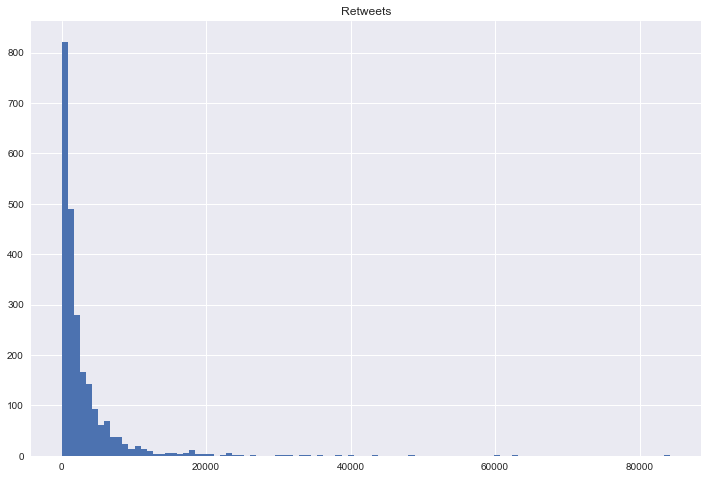

In [22]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import numpy as np
from numpy.polynomial.polynomial import polyfit


plt.figure(figsize=(12,8))
plt.hist(tweet_df['retweet_count'].dropna(),bins=100)
plt.title('Retweets')

This chart is not that illuminating because of the outliers. About 30 posts have more than 20,000 retweets. 

In [211]:
tweet_df.sort_values('retweet_count',ascending=False)['retweet_count'].head(30)

829     84241.0
868     62399.0
421     59893.0
327     48056.0
60      43708.0
352     40285.0
423     38523.0
115     35692.0
1539    33952.0
1601    32908.0
674     31630.0
142     31027.0
359     29851.0
475     26379.0
99      26268.0
502     24550.0
131     23779.0
1400    23265.0
866     23007.0
417     22936.0
735     22745.0
351     20763.0
1515    20253.0
38      20192.0
1033    19548.0
719     19004.0
68      18886.0
314     18793.0
7       18609.0
156     18359.0
Name: retweet_count, dtype: float64

I leave those very popular tweets out and I chart the rest:

Text(0.5,1,'Retweets')

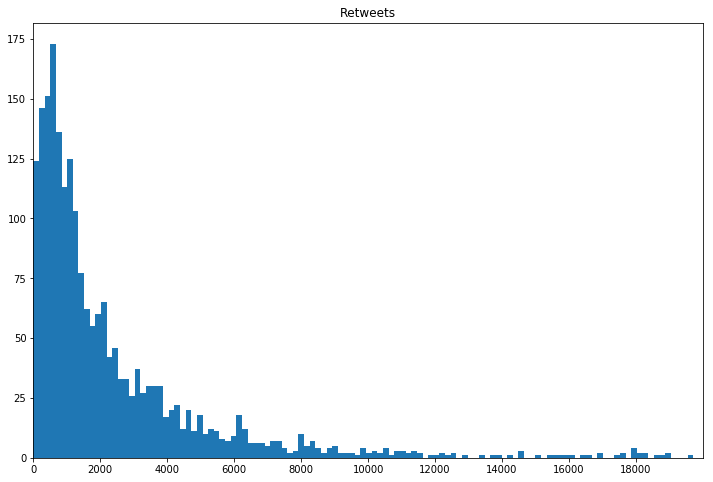

In [212]:
plt.figure(figsize=(12,8))
plt.hist(tweet_df['retweet_count'].dropna(),bins=500)
plt.xlim(0,20000)
plt.xticks(np.arange(0, 20000, 2000))
plt.title('Retweets')

Next I look at the distribution of the number of likes:

Text(0.5,1,'Likes')

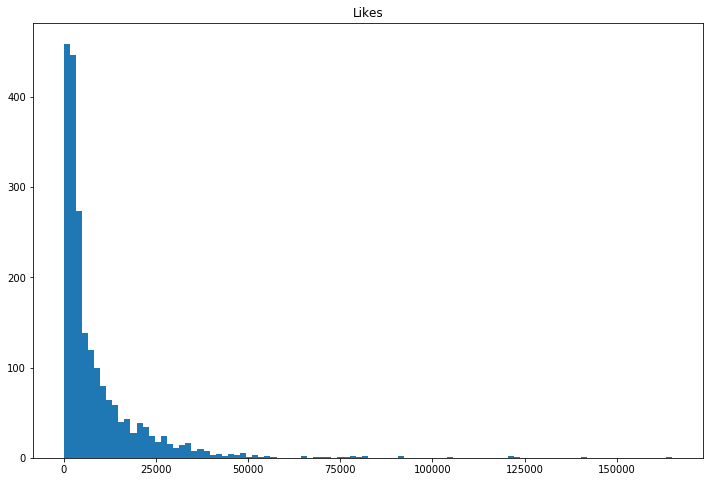

In [213]:
plt.figure(figsize=(12,8))
plt.hist(tweet_df['favorite_count'].dropna(),bins=100)
plt.title('Likes')

We have the same problem here. So I remove the outliers and draw the chart again:

In [214]:
tweet_df.sort_values('favorite_count',ascending=False)['favorite_count'].head(30)

829     165048.0
327     141186.0
115     122604.0
868     122061.0
421     121184.0
60      104586.0
352      92416.0
142      91211.0
1539     82407.0
99       82298.0
423      80846.0
68       78865.0
1601     77897.0
34       76478.0
131      75257.0
38       72096.0
282      70960.0
22       68169.0
106      65539.0
7        64574.0
289      56252.0
359      55537.0
314      55413.0
475      53733.0
674      52801.0
116      52769.0
901      51734.0
50       49937.0
51       48824.0
502      48670.0
Name: favorite_count, dtype: float64

Text(0.5,1,'Likes')

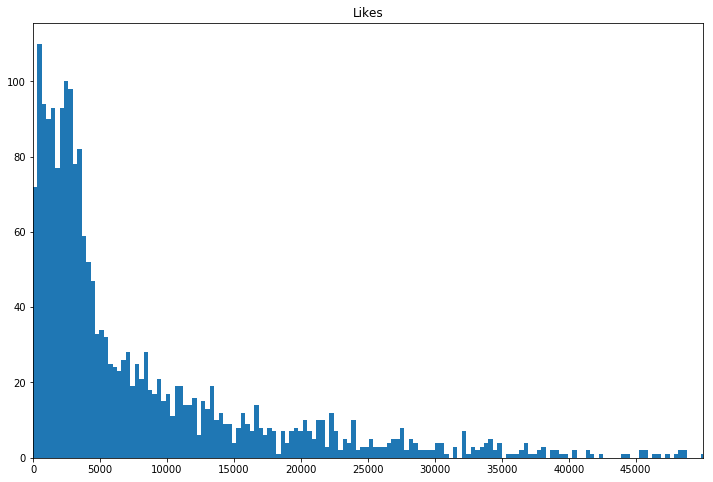

In [215]:
plt.figure(figsize=(12,8))
plt.hist(tweet_df['favorite_count'].dropna(),bins=500)
plt.xlim(0,50000)
plt.xticks(np.arange(0, 50000, 5000))
plt.title('Likes')

Let's see the most retweeted tweet:

In [216]:
max_retweet=tweet_df['favorite_count'].max()
index=tweet_df[tweet_df['favorite_count']==max_retweet].index.values[0]
print tweet_df.loc[index,'expanded_urls']

https://twitter.com/dog_rates/status/744234799360020481/video/1


(This is just another method to extract the same thing):

In [217]:
print tweet_df.loc[tweet_df['retweet_count'].idxmax(),'expanded_urls']

https://twitter.com/dog_rates/status/744234799360020481/video/1


I look at the text for the most retweeted tweets:

In [218]:
for index in tweet_df['retweet_count'].sort_values(ascending=False).head().index:
    print tweet_df.loc[index,'text']

Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC
This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
Here's a super supportive puppo participating in the Toronto  #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY


... and for the most liked tweets:

In [219]:
for index in tweet_df['favorite_count'].sort_values(ascending=False).head().index:
    print tweet_df.loc[index,'text']

Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Here's a super supportive puppo participating in the Toronto  #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr
Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC
This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d


Next I want to see if there is a correlation between the number of likes a tweet has and the number of times it has been retweeted. I use a simple scatterplot for this:

Text(0,0.5,'Likes')

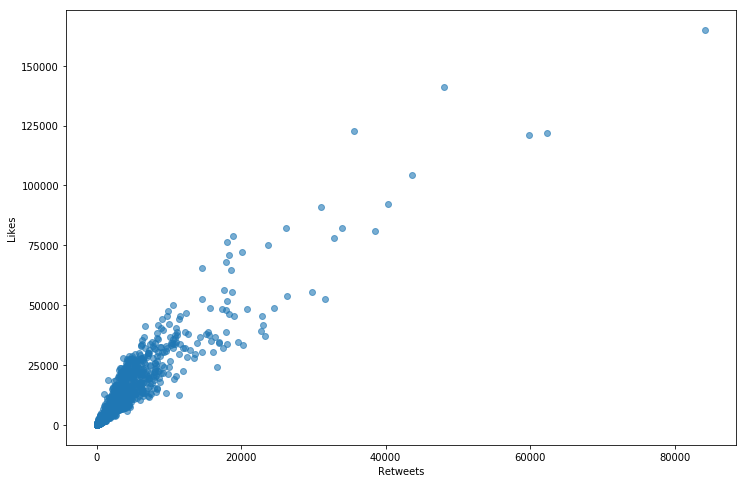

In [220]:
plt.figure(figsize=(12,8))

plt.scatter(tweet_df['retweet_count'],tweet_df['favorite_count'],alpha=.6)
plt.xlabel('Retweets')
plt.ylabel('Likes')

...and I zoom in to those tweets that have less than 6,000 retweets.

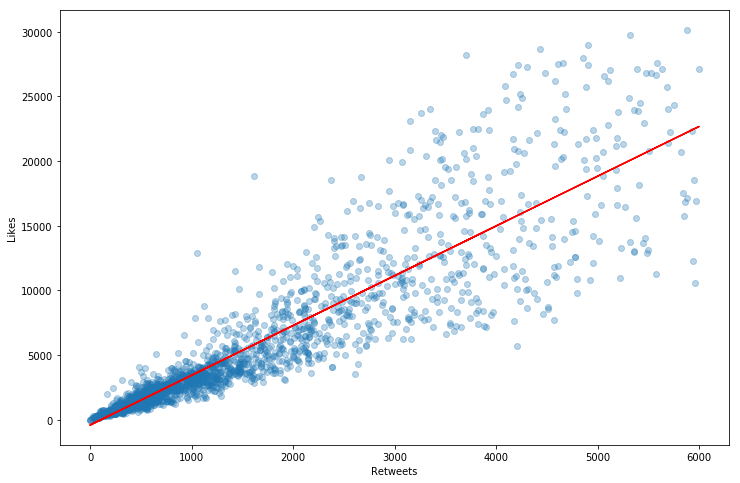

In [221]:
small_df=tweet_df[tweet_df['retweet_count']<6000]
plt.figure(figsize=(12,8))
x=small_df['retweet_count']
y=small_df['favorite_count']
plt.scatter(x,y,alpha=.3)
plt.xlabel('Retweets')
plt.ylabel('Likes')

b, m = polyfit(x, y, 1)
plt.plot(x, b + m * x, '-',color='red')

Next I look at the most popular hashtags:

In [222]:
hashtag_df['hashtag'].value_counts().head(10)

BarkWeek           9
PrideMonth         4
ImWithThor         1
PrideMonthPuppo    1
notallpuppers      1
WomensMarch        1
WKCDogShow         1
ScienceMarch       1
K9VeteransDay      1
swole              1
Name: hashtag, dtype: int64

Unfortunately, it looks like the data here is very sparse.

In [223]:
hashtag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
hashtag     26 non-null object
tweet_id    26 non-null object
dtypes: object(2)
memory usage: 488.0+ bytes


I create a `rating` column:

In [224]:
tweet_df['rating_numerator']=tweet_df['rating_numerator'].astype(float)
tweet_df['rating_denominator']=tweet_df['rating_denominator'].astype(float)
temp_df=tweet_df.dropna(subset=['rating_denominator'],axis=0)

for i in temp_df.index:
    if tweet_df.loc[i,'rating_numerator'] is not None:
        tweet_df.loc[i,'rating']=float(tweet_df.loc[i,'rating_numerator']/tweet_df.loc[i,'rating_denominator'])

In [ ]:
tweet_df.sort_values('rating',ascending=False)['rating'].head(0)

The highest rating is just a play on the Declaration of Independence year, and the second highest rating belongs to Snoop Dog. So the highest authentic ratings are 1.4, which seem to be pretty common. Let's see if there is any relationship between ratings on the one hand, and retweets and likes on the other. First retweetsL

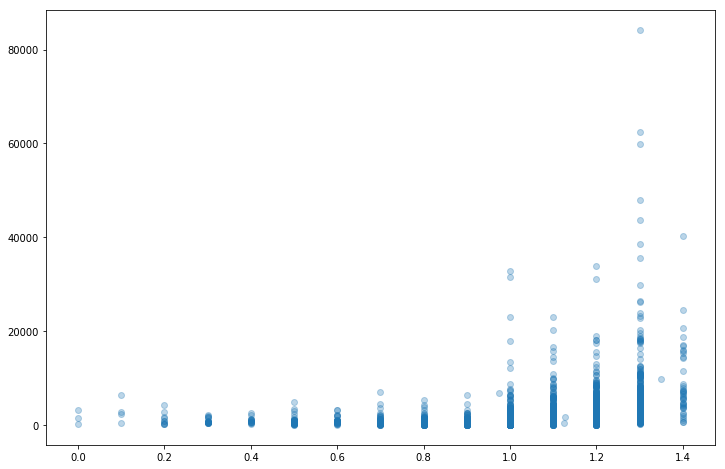

In [239]:
plt.figure(figsize=(12,8))
temp_df=tweet_df.drop([772,1838],axis=0)
plt.scatter(temp_df['rating'],temp_df['retweet_count'],alpha=.3)

...then likes. 

Text(0.5,1,'Likes versus Ratings')

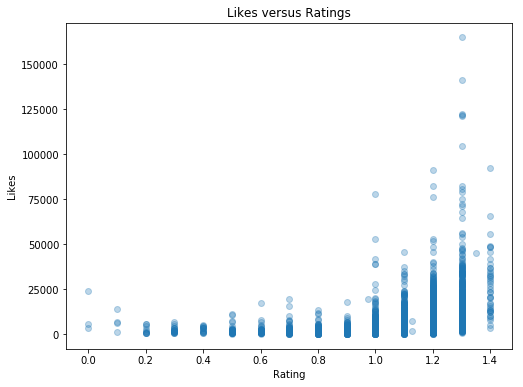

In [240]:
plt.figure(figsize=(8,6))
plt.scatter(temp_df['rating'],temp_df['favorite_count'],alpha=.3)
plt.xlabel('Rating')
plt.ylabel('Likes')
plt.title('Likes versus Ratings')

I look at the relationship between likes and ratings in a diffeent way - by checking the average number of likes for tweets with a certain rating:

In [228]:
temp_df=tweet_df.drop([782,1850],axis=0)

for i in temp_df.index:
    temp_df.loc[i,'rating']=int(temp_df.loc[i,'rating']*10)
    
# temp_df.sort_values('rating',ascending=False)['rating'].head(30)

# temp_df['rating']=temp_df['rating'].astype(int)
# temp_df.groupby('rating')['favorite_count'].count()
temp_df=temp_df.groupby('rating')['favorite_count'].mean().to_frame('average_likes').reset_index().loc[1:14,]
temp_df

,rating,average_likes
1,1.0,6848.250000
2,2.0,2375.700000
3,3.0,2301.157895
4,4.0,2639.400000
5,5.0,2535.878788
6,6.0,2614.031250
7,7.0,2909.666667
8,8.0,2320.591837
9,9.0,2454.358974
10,10.0,4092.173913


Text(0.5,1,'Average Likes per Rating')

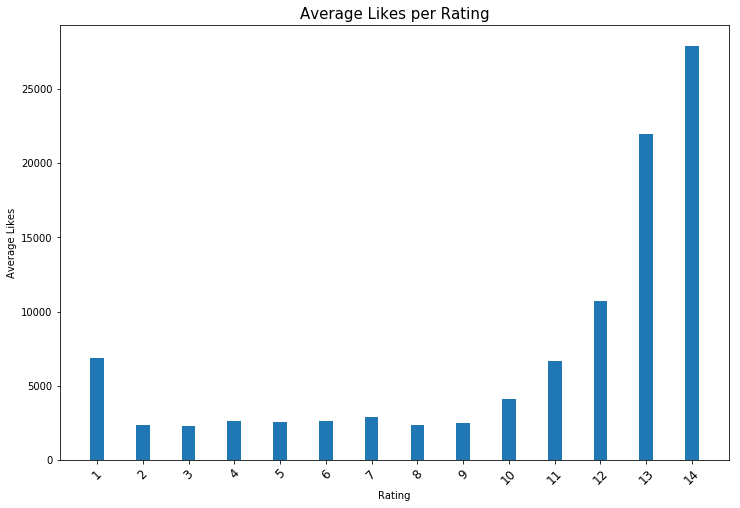

In [229]:
import numpy as np 
plt.figure(figsize=(12,8))

index=np.arange(temp_df.shape[0])
labels=np.arange(1,15)
# plt.bar(index,temp_df['average_likes'],align='edge',width=.6)

plt.bar(index,temp_df['average_likes'],width=.3)
plt.xticks(index, labels, fontsize=12, rotation=45)
plt.xlabel('Rating')
plt.ylabel('Average Likes')
plt.title('Average Likes per Rating',fontsize=15)

In [230]:
# temp_df=tweet_df.drop([979,2074],axis=0)

# plt.figure(figsize=(12,8))
# plt.scatter(temp_df['rating'],temp_df['favorite_count'],alpha=.3)
# plt.ylim((0,25000))

Next I look at the distribution of posts over time - first over months of the year, next over days in the week, and finally over the course of a day.

In [231]:
tweet_df['month_sent']=tweet_df['timestamp'].dt.month

month_list=['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(tweet_df.shape[0]):
    tweet_df.loc[i,'month_sent']=month_list[int(tweet_df.loc[i,'month_sent'])-1]
    
tweet_df['day_sent']=tweet_df['timestamp'].dt.weekday

weekday_list=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(tweet_df.shape[0]):
    tweet_df.loc[i,'day_sent']=weekday_list[tweet_df.loc[i,'day_sent']]
    
tweet_df['hour_sent']=tweet_df['timestamp'].dt.hour

<BarContainer object of 12 artists>

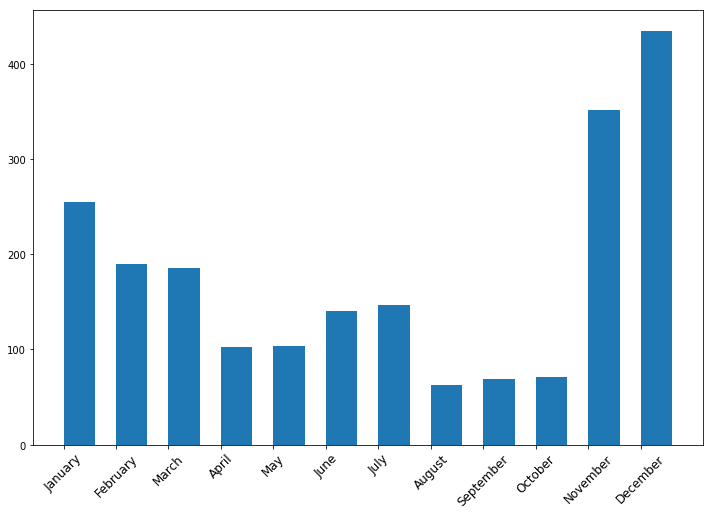

In [232]:
plt.figure(figsize=(12,8))
serie=tweet_df['month_sent'].value_counts()
serie=serie.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
serie
index=np.arange(len(serie))
labels=['January','February','March','April','May','June','July','August','September','October','November','December']
plt.xticks(index, labels, fontsize=12, rotation=45)
plt.bar(index,serie.values,align='edge',width=.6)


November and December have an unusually high number of posts. This might be because the time interval contains more November and December months than other months. Let's check:

In [233]:
print min(tweet_df['timestamp'])
print max(tweet_df['timestamp'])

2015-11-15 22:32:08
2017-08-01 16:23:56


It looks like November and December do indeed have a higher number of posts on average than other months - but the time range explains why August, September and October have a lower number of posts. Let's look only at the 2016 posts, to have a better sense of the distribution of posts per month.

<BarContainer object of 12 artists>

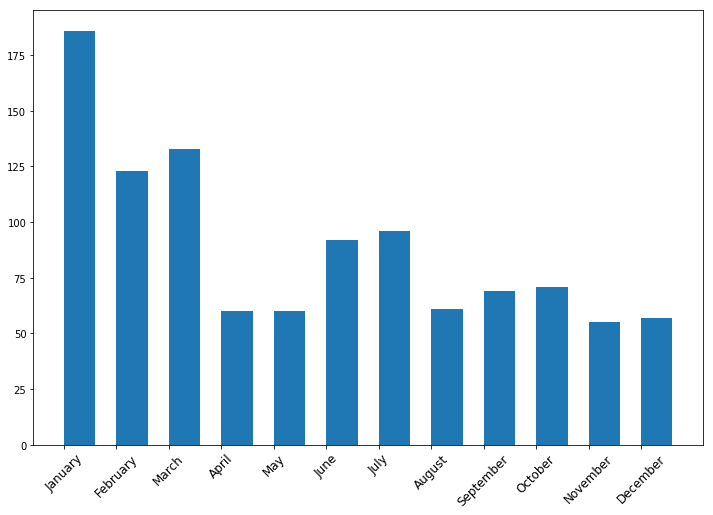

In [234]:
plt.figure(figsize=(12,8))
criterion=(tweet_df['timestamp']>'2016-01-01 00:00:01') & (tweet_df['timestamp']<'2016-12-31 23:59:59')
temp_df=tweet_df[criterion]
serie=temp_df['month_sent'].value_counts()
serie=serie.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
serie
index=np.arange(len(serie))
labels=['January','February','March','April','May','June','July','August','September','October','November','December']
plt.xticks(index, labels, fontsize=12, rotation=45)
plt.bar(index,serie.values,align='edge',width=.6)


Monday       351
Tuesday      316
Wednesday    314
Thursday     299
Friday       295
Saturday     271
Sunday       269
Name: day_sent, dtype: int64


<BarContainer object of 7 artists>

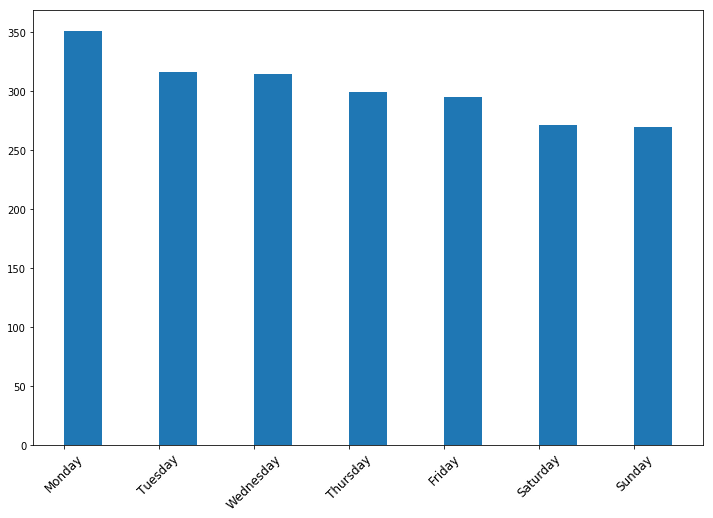

In [235]:
plt.figure(figsize=(12,8))
serie=tweet_df['day_sent'].value_counts()
print serie

serie=serie.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

index=np.arange(len(serie))
labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(index, labels, fontsize=12, rotation=45)
plt.bar(index,serie.values,align='edge',width=.4)


Text(0.5,1,'Distribution of Tweets Over the Course of A Day')

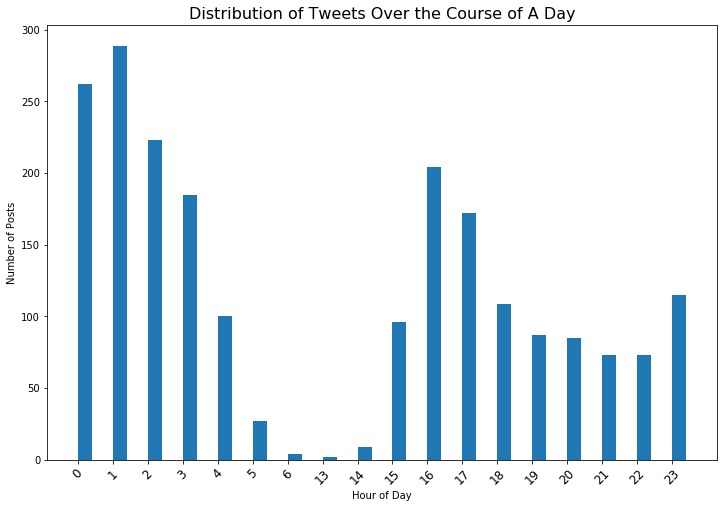

In [236]:
plt.figure(figsize=(12,8))
serie=tweet_df['hour_sent'].value_counts()
# print serie
# serie=serie.reindex(['0','1','2','3','4','5','6','13','14','15','16','17','18','19','20','21','22','23'])
serie=serie.reindex([0,1,2,3,4,5,6,13,14,15,16,17,18,19,20,21,22,23])

ind=np.arange(len(serie))

labels=serie.index
plt.xticks(ind,labels, fontsize=12, rotation=45)
plt.bar(ind,serie.values,align='edge',width=.4)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.title('Distribution of Tweets Over the Course of A Day',fontsize=16)


The distribution of tweets over the course of a day is a little odd. Either the owner of this account is a night owl, or he lives in a different timezone than the one recorded in the tweet's timestamps. An internet search reveals that the owner, Matt Nelson, lives in West Virginia, and that the timestamps indicate West Coast times. I adjust the times to the East Coast, and I draw the bar chart once more:

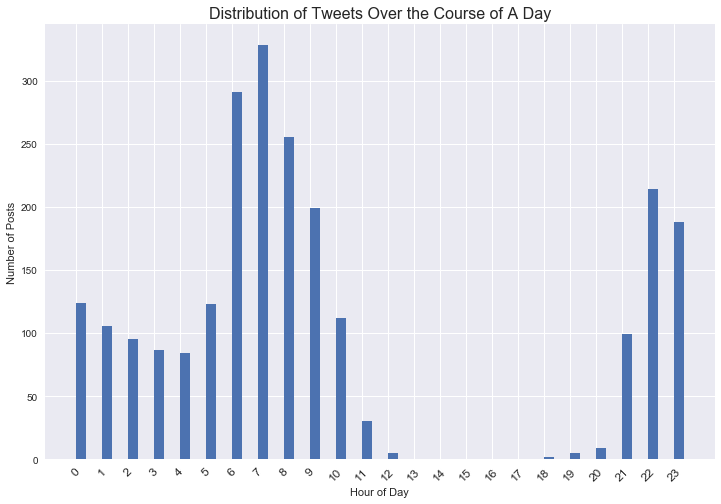

In [23]:
import datetime
tweet_df['timestamp']=tweet_df['timestamp']+datetime.timedelta(hours=3)
tweet_df['hour_sent']=tweet_df['timestamp'].dt.hour

plt.figure(figsize=(12,8))
serie=tweet_df['hour_sent'].value_counts()
# serie=serie.reindex(['0','1','2','3','4','5','6','13','14','15','16','17','18','19','20','21','22','23'])
serie=serie.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

ind=np.arange(len(serie))

labels=serie.index
plt.xticks(ind,labels, fontsize=12, rotation=45)
plt.bar(ind,serie.values,align='edge',width=.4)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.title('Distribution of Tweets Over the Course of A Day',fontsize=16)

Even after correcting for the timezone difference, it looks like Matt Nelson is a night owl - most of his tweets are posted in the evening or very late at night. (Or he schedules his tweets at very late hours). 